In [1]:
import pandas as pd
import os
from skimage.io import imread, imshow
from skimage.transform import rescale, resize
from skimage.feature.texture import greycoprops,greycomatrix



In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
#import mahotas
#import cv2
import matplotlib.pyplot as plt
from scipy.stats import skew,kurtosis,norm,moment


In [5]:
%matplotlib inline

In [24]:
root_dir='C:\\Users\\RASHKE JAHAN'
data_dir=root_dir+'\\malaria_data'
#training_img_dir=data_dir+'\\Training'
#test_img_dir=data_dir+'\\Test'
img_array=cv2.imread(r'C:\Users\RASHKE JAHAN\malaria_data\Parasitized\C33P1thinF_IMG_20150619_114756a_cell_179.png')
#img=imshow(img_array)
#print(img_array)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
plt.show

NameError: name 'cv2' is not defined

In [6]:
# fixed-sizes for image
fixed_size = tuple((64, 64))


# no.of.trees for Random Forests
num_trees = 50

# bins for histogram
bins = 8


# seed for reproducing same results
seed = 9

In [9]:
# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [10]:
# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

In [21]:
# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    #hist  = cv2.calcHist([image], [0, 1, 2], None, [bins,bins,bins], [0, 256, 0, 256, 0, 256])
    hist  = cv2.calcHist([image], [0], None, [256], [0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()
    #return hist

In [13]:
labels = os.listdir(data_dir)
print(labels)

['Parasitized', 'Uninfected']


In [51]:
%%time
image_list=[]
gray_image_list=[]
# loop over the training data sub-folders
for name in labels:
    # join the training data path and each species training folder
    #dir = os.path.join(train_path, training_name)
    label_path=os.path.join(data_dir,name)
    # get the current training label
    for img in os.listdir(label_path)[:4]:
        try:

        # read the image and resize it to a fixed-size
            image = cv2.imread(os.path.join(label_path,img))
            
            #image = cv2.resize(image, fixed_size)
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # update the list of labels and feature vectors
            image_list.append(image)
            gray_image_list.append(gray_image)
        except Exception as e:
            pass

Wall time: 113 ms


In [52]:
len(image_list)
image_list[0].shape

(148, 142, 3)

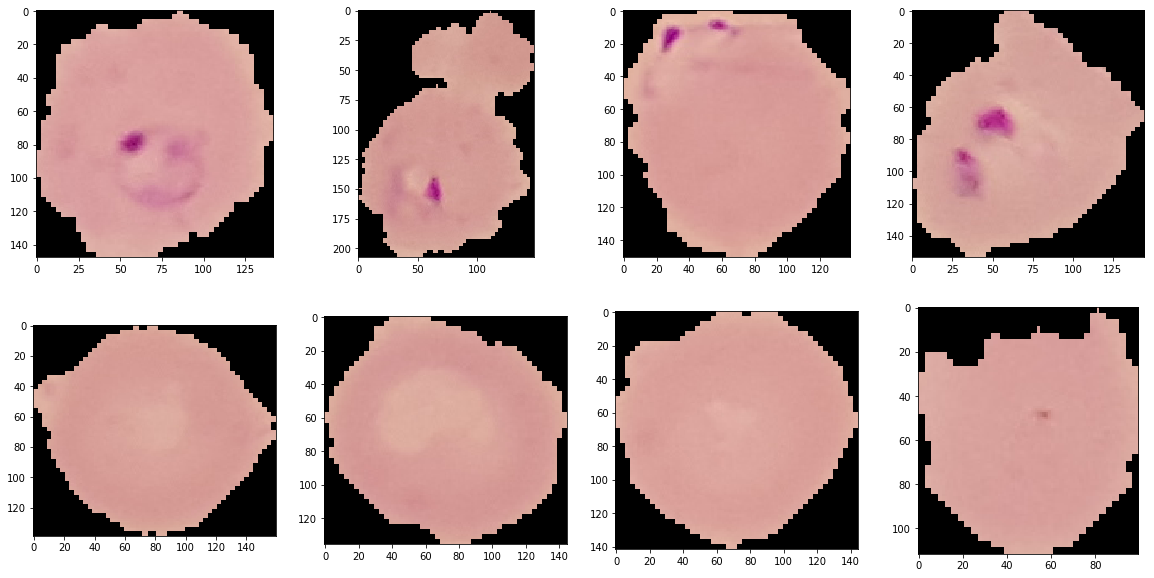

In [16]:
fig = plt.figure(figsize=(20,10))
for i,img in enumerate(image_list):
    
    plt.subplot(2, 4, i+1)
    plt.imshow(cv2.cvtColor(image_list[i], cv2.COLOR_BGR2RGB))
    
plt.show()


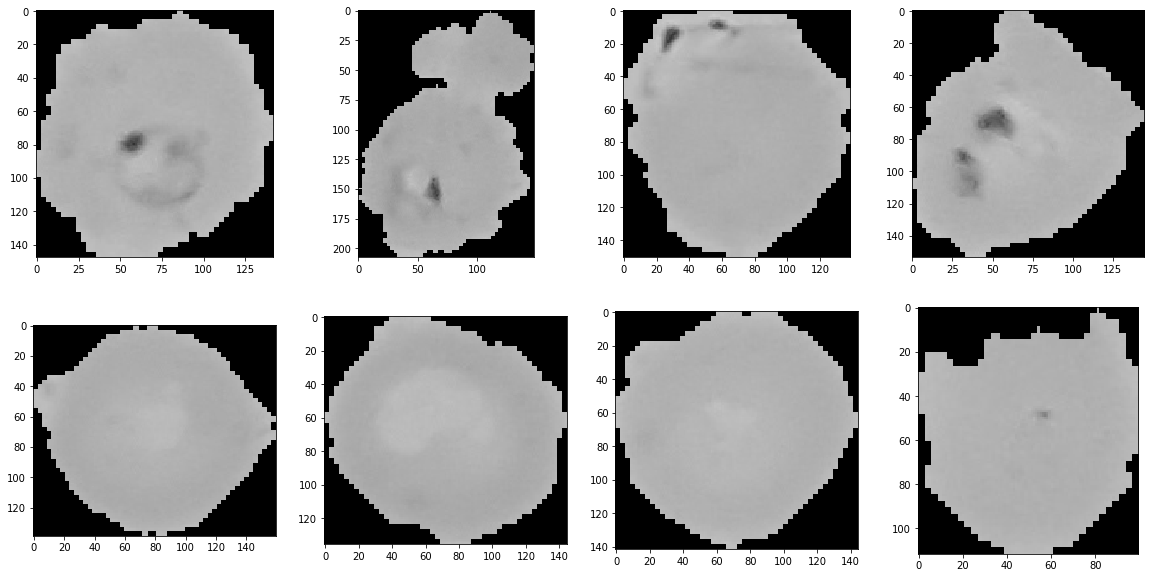

In [17]:
fig = plt.figure(figsize=(20,10))
for i,img in enumerate(gray_image_list):
    
    plt.subplot(2, 4, i+1)
    plt.imshow(cv2.cvtColor(gray_image_list[i], cv2.COLOR_BGR2RGB))
    
plt.show()

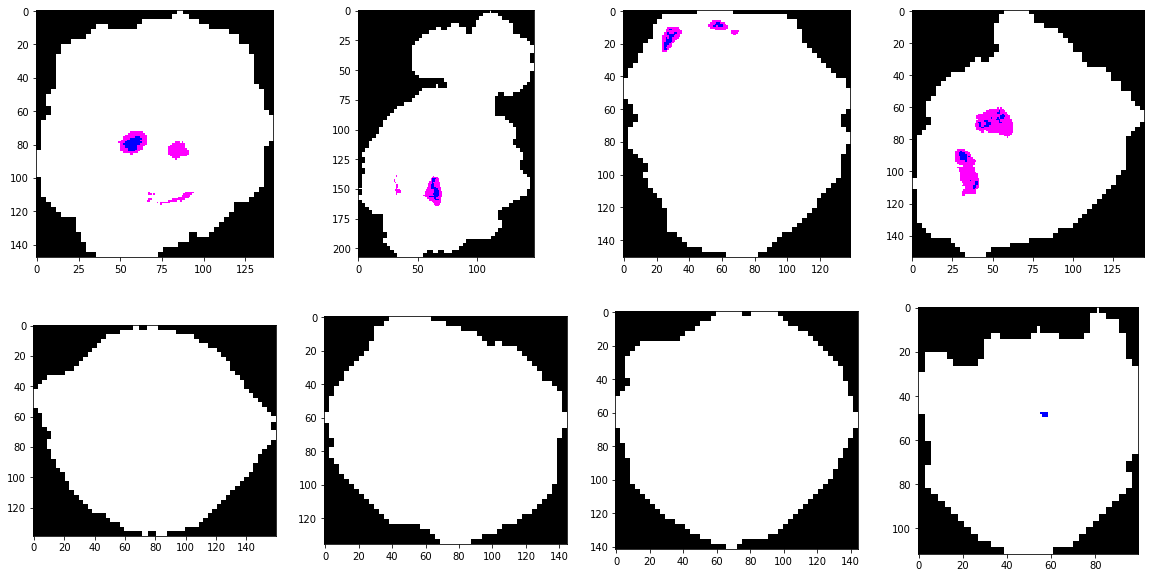

In [19]:
fig = plt.figure(figsize=(20,10))
for i,img in enumerate(image_list):
    
    plt.subplot(2, 4, i+1)
    
    ret1,th = cv2.threshold(image_list[i],127,255,cv2.THRESH_BINARY)
    plt.imshow(th)
    
plt.show()

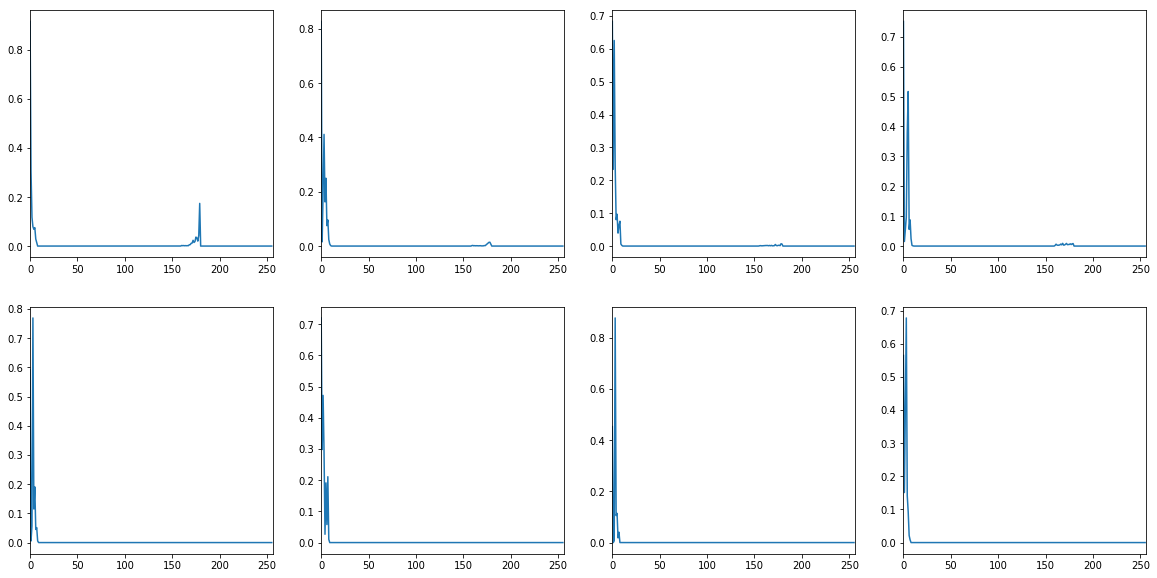

In [22]:
fig = plt.figure(figsize=(20,10))
for i,img in enumerate(image_list):
    fv_histogram  = fd_histogram(img)
    
    plt.subplot(2, 4, i+1)
    plt.plot(fv_histogram)
    plt.xlim([0,256])
    
plt.show()


## function for histogram statistical featurtes

In [54]:
def stats(array):
    size=len(array)
    prob_dens=1/size
    skew=0
    var=0
    mean=np.mean(array)
    kurtosis=0
    for k in np.nditer(array):
        kurtosis= kurtosis+(((k-mean)**4)*prob_dens-3)
        skew=skew+((k-mean)**3)*prob_dens 
        var=var+((k-mean)**2)*prob_dens

    skew=skew*(var**-3/2)
    kurtosis= kurtosis*(var**-2)
    return mean,var,skew,kurtosis 

In [60]:
histogram_mean=[]
histogram_variance=[]
histogram_skew=[]
histogram_kurtosis=[]
for i,img in enumerate(image_list):
    hist= fd_histogram(img)
    mean,var,skew,kurtosis= stats(hist)
    histogram_mean.append(mean)
    histogram_variance.append(var)
    histogram_skew.append(skew)
    histogram_kurtosis.append(kurtosis)

len(histogram_mean)

8

In [61]:
print(histogram_mean)


[0.0078765629, 0.0083949054, 0.0085900752, 0.0081643434, 0.0071533723, 0.0089003555, 0.0063083819, 0.0080811856]


In [62]:
print(histogram_variance)

[0.0038442099151838115, 0.0038357757384283918, 0.003832460225186414, 0.0038395936686320062, 0.0038550791252411521, 0.0038270337734200798, 0.0038664547541248906, 0.0038409440589257898]


In [64]:
def texture_feature(gray_img_list):
    x=[]
    y=[]
    z=[]
    p=[]
    q=[]
    for img in gray_image_list:
        g = greycomatrix(img,[1],[np.pi],  normed=True, symmetric=True)
        contrast = greycoprops(g, 'contrast')
        energy = greycoprops(g, 'energy')
        correlation = greycoprops(g, 'correlation')
        homogeneity = greycoprops(g, 'homogeneity')
        ASM = greycoprops(g, 'ASM')
        x.append(round(np.asscalar(contrast),3))
        y.append(round(np.asscalar(energy),3))
        z.append(round(np.asscalar(correlation),3))
        p.append(round(np.asscalar(homogeneity),3))
        q.append(round(np.asscalar(ASM),3))
    return x, y, z,p,q



In [65]:
x,y,z,p,q=texture_feature(gray_image_list)

data={"mean":histogram_mean,"variance":histogram_variance,"skewness":histogram_skew,"kurtosis":histogram_kurtosis,"contrast":x,"energy":y,"correlation":z,"homogeneity":p,"ASM":q}

In [67]:

features=pd.DataFrame(data,index=["I1","I2","I3","I4","I5","I6","I7","I8"])
features

,ASM,contrast,correlation,energy,homogeneity,kurtosis,mean,skewness,variance
I1,0.067,466.193,0.960,0.259,0.675,-5.196914e+07,0.007877,26878.297892,0.003844
I2,0.123,475.662,0.965,0.351,0.704,-5.219799e+07,0.008395,22184.756294,0.003836
I3,0.071,450.214,0.961,0.266,0.712,-5.228837e+07,0.008590,19697.823003,0.003832
I4,0.127,468.693,0.968,0.356,0.700,-5.209425e+07,0.008164,20504.089768,0.003840
I5,0.110,397.661,0.970,0.331,0.768,-5.167656e+07,0.007153,22172.967349,0.003855
I6,0.081,439.669,0.964,0.284,0.721,-5.243677e+07,0.008900,18107.414238,0.003827
I7,0.086,440.114,0.966,0.294,0.745,-5.137289e+07,0.006308,25375.709545,0.003866
I8,0.083,587.725,0.953,0.288,0.729,-5.205765e+07,0.008081,18767.234778,0.003841


In [23]:
# get the training labels


# sort the training labels
labels.sort()
print(len(labels))

# empty lists to hold feature vectors and labels
global_features = []
labels_code = []
data_list=[]




NameError: name 'labels' is not defined

In [38]:
labels

['Parasitized', 'Uninfected']

# feature extraction 

In [ ]:
%%time
# loop over the training data sub-folders
for name in labels:
    # join the training data path and each species training folder
    #dir = os.path.join(train_path, training_name)
    label_path=os.path.join(data_dir,name)
    # get the current training label
    current_label = name
    #print(name)
    # loop over the images in each sub-folder

    label_code=labels.index(name)
    
    for img in os.listdir(label_path):
        try:

        # read the image and resize it to a fixed-size
            image = cv2.imread(os.path.join(label_path,img))
            image = cv2.resize(image, fixed_size)
        #image = resize(image, (50, 50), mode='reflect')
            #print('resized')
        ####################################
        # Global Feature extraction
        ####################################
            fv_hu_moments = fd_hu_moments(image)
            fv_haralick   = fd_haralick(image)
            fv_histogram  = fd_histogram(image)
            #print('features extracted')

        ###################################
        # Concatenate global features
        ###################################
            global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

        # update the list of labels and feature vectors
            labels_code.append(current_label)
            global_features.append(global_feature)
            data_list.append([global_feature,label_code])
        except Exception as e:
            pass
    print("[STATUS] processed folder: {}".format(current_label))

print("[STATUS] completed Global Feature Extraction...")

In [36]:
len(data_list)

27558

In [1]:
#data_list[0]

In [70]:
from sklearn.externals import joblib

In [41]:
import random
random.shuffle(data_list)
type(data_list)

list

In [44]:
X=[]
y=[]

In [45]:
for feature, label in data_list:
    X.append(feature)
    y.append(label)


In [47]:
X=np.array(X)
y=np.array(y)

In [71]:
X.shape

NameError: name 'X' is not defined

In [54]:
y.shape

(27558,)

In [52]:
data={'feature':X,'label':y}

# run from here

In [7]:
from sklearn.externals import joblib

### dont run

In [54]:
joblib.dump(data,'malaria_dataset')

['malaria_dataset']

In [8]:
data_set=joblib.load('malaria_dataset')

In [82]:
X=data_set['feature']
y=data_set['label']

In [83]:
y.shape

(27558,)

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
scalify = StandardScaler()

In [14]:
%%time
scalify.fit(X)

Wall time: 461 ms


StandardScaler(copy=True, with_mean=True, with_std=True)

In [15]:
%%time
X_train_prepared=scalify.transform(X)

Wall time: 277 ms


In [16]:

from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [29]:
X_train,X_test,y_train,y_test=train_test_split(X_train_prepared,y,test_size=.10, random_state=seed)

In [21]:
def clf_stastics(clf,test_set):
    y_pred=clf.predict(test_set)
    return[accuracy_score(y_test,y_pred),recall_score(y_test,y_pred),precision_score(y_test,y_pred)]

In [22]:
class_names = labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)



NameError: name 'labels' is not defined

# Importing SGD classifier

In [25]:
from sklearn.linear_model import SGDClassifier

In [30]:
%%time
sgd_clf = SGDClassifier( random_state=42,max_iter=1000, tol=1e-3, loss="log", penalty="l2",n_jobs=-1,alpha=0.001)
sgd_clf.fit(X_train, y_train)

Wall time: 410 ms


In [27]:
from sklearn.metrics import accuracy_score
y_pred_sgd = sgd_clf.predict(X_test)
#predict 30 samples of test data set
print('prediction of 30 samples of test data set\n')
print(y_pred_sgd[:30])
print(y_test[:30])
print('\n')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_sgd, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_sgd, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#print accuracy, recall and precision
print('accuracy, recall and precision')
sgd_stats=clf_stastics(sgd_clf,X_test)
print(sgd_stats)

prediction of 30 samples of test data set

[1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1 0 1 1 0]
[1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1]




NameError: name 'plot_confusion_matrix' is not defined

In [32]:
#
sgd_stats=clf_stastics(sgd_clf,X_test)
sgd_stats

[0.9071117561683599, 0.9367088607594937, 0.8891855807743658]

# logistic regression

In [33]:
from sklearn.linear_model import LogisticRegression
lgr_clf=LogisticRegression(solver='lbfgs', multi_class='multinomial',random_state=9,C=100)

In [34]:
%%time
lgr_clf.fit(X_train,y_train)

Wall time: 4.43 s


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=9, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [35]:
%%time
from sklearn.metrics import accuracy_score
y_pred_lgr=lgr_clf.predict(X_test)
print(y_pred_lgr[:30])
print(y_test[:30])

[1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1 0 0 1 0]
[1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1]
Wall time: 9 ms


prediction of 30 samples of test data set

[1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1 0 0 1 0]
[1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1]


Confusion matrix, without normalization
[[1192  142]
 [  72 1350]]
Normalized confusion matrix
[[ 0.89  0.11]
 [ 0.05  0.95]]


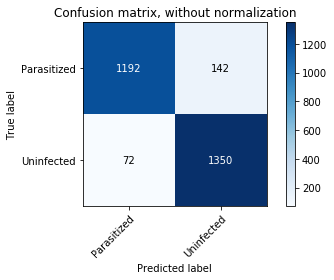

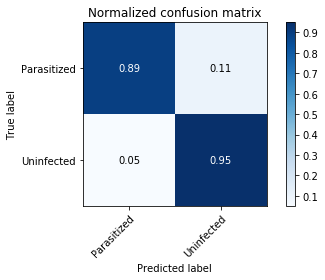

accuracy, recall and precision
[0.92235123367198835, 0.94936708860759489, 0.9048257372654156]


In [93]:

from sklearn.metrics import accuracy_score
y_pred_lgr = lgr_clf.predict(X_test)
#predict 30 samples of test data set
print('prediction of 30 samples of test data set\n')
print(y_pred_lgr[:30])
print(y_test[:30])
print('\n')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_lgr, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_lgr, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#print accuracy, recall and precision
print('accuracy, recall and precision')
lgr_stats=clf_stastics(lgr_clf,X_test)
print(lgr_stats)


# decision tree

In [36]:
from sklearn.tree import DecisionTreeClassifier
dtc_clf=DecisionTreeClassifier(random_state=9)

In [37]:
dtc_clf.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=9,
            splitter='best')

In [38]:
%%time
from sklearn.metrics import accuracy_score
y_pred_dtc=dtc_clf.predict(X_test)
print(y_pred_dtc[:30])
print(y_test[:30])
print(accuracy_score(y_test,y_pred_dtc))

[1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 1 0 1 0 0 1 1 0 1 0]
[1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1]
0.9343251088534107
Wall time: 25 ms


prediction of 30 samples of test data set

[1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 1 0 1 0 0 1 1 0 1 0]
[1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1]


Confusion matrix, without normalization
[[1246   88]
 [  93 1329]]
Normalized confusion matrix
[[ 0.93  0.07]
 [ 0.07  0.93]]


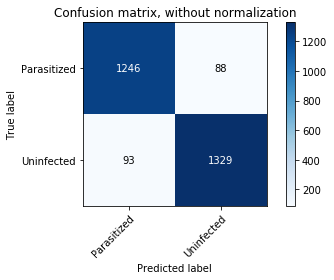

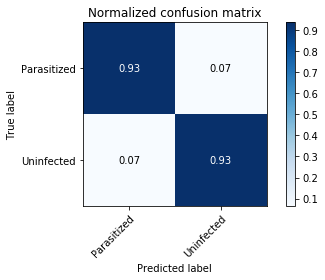

accuracy, recall and precision
[0.93432510885341069, 0.93459915611814348, 0.9378969654199012]


In [98]:
from sklearn.metrics import accuracy_score
y_pred_dtc = dtc_clf.predict(X_test)
#predict 30 samples of test data set
print('prediction of 30 samples of test data set\n')
print(y_pred_dtc[:30])
print(y_test[:30])
print('\n')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_dtc, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_dtc, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#print accuracy, recall and precision
print('accuracy, recall and precision')
dtc_stats=clf_stastics(dtc_clf,X_test)
print(dtc_stats)


In [39]:
from sklearn. ensemble import AdaBoostClassifier, VotingClassifier


In [71]:
 evc_clf = VotingClassifier( estimators= [('lgr_clf',lgr_clf),('dtc_clf',dtc_clf),('sgd_clf',sgd_clf)],voting='soft')

In [41]:
evc_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('lgr_clf', LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=9, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)), ('dtc_cl...y='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=0.001, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [58]:
from sklearn.metrics import accuracy_score
y_pred_evc=evc_clf.predict(X_test)
print(y_pred_evc[30:60])
print(y_test[30:60])
print(accuracy_score(y_test,y_pred_evc))

[0 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 1 1 1 0 0]
[0 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 0 0]
0.9466618287373004


C:\Users\rishu\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


C:\Users\rishu\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\rishu\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\rishu\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\rishu\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

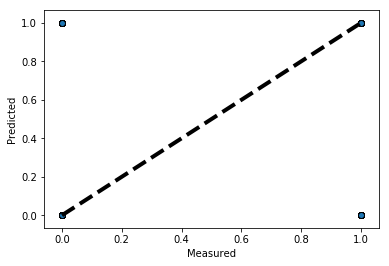

In [64]:
from sklearn import datasets
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt

lr = linear_model.LinearRegression()
boston = datasets.load_boston()


# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(VotingClassifier(estimators= [('lgr_clf',lgr_clf),('dtc_clf',dtc_clf),('sgd_clf',sgd_clf)],voting='soft'), X_train_prepared, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Automatically created module for IPython interactive environment


C:\Users\rishu\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


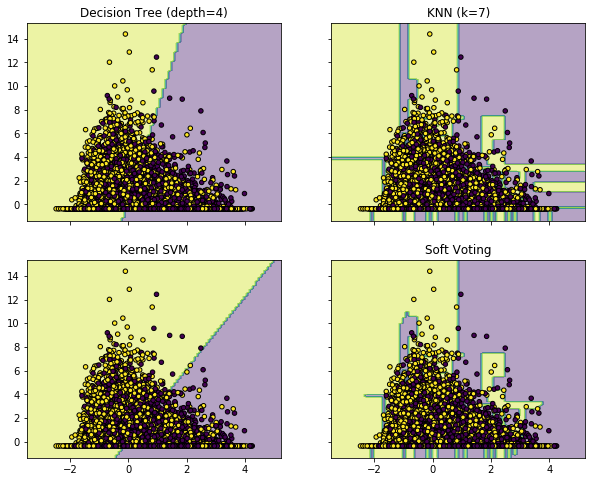

In [86]:
print(__doc__)

from itertools import product

import numpy as np
import matplotlib.pyplot as plt



# Loading some example data
iris = datasets.load_iris()
X = X_train_prepared[:, [0, 2]]

# Training classifiers


sgd_clf.fit(X, y)
dtc_clf.fit(X, y)
lgr_clf.fit(X, y)
evc_clf.fit(X, y)

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [sgd_clf, dtc_clf, lgr_clf, evc_clf],
                        ['Decision Tree (depth=4)', 'KNN (k=7)',
                         'Kernel SVM', 'Soft Voting']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

In [85]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
print(__doc__)

import matplotlib.pyplot as plt
import numpy as np

#from sklearn.datasets import load_digits
#digits = load_digits()

from sklearn.model_selection import validation_curve

#X, y = digits.data, digits.target
X, y = X_train_prepared, y

param_range =  np.arange(1, 100, 1)
train_scores, test_scores = validation_curve(
    AdaBoostClassifier(random_state=9,base_estimator=evc_clf), X, y, param_name='n_estimators', param_range=param_range,
    cv=5, scoring="accuracy", n_jobs=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Automatically created module for IPython interactive environment


KeyboardInterrupt: 

Automatically created module for IPython interactive environment


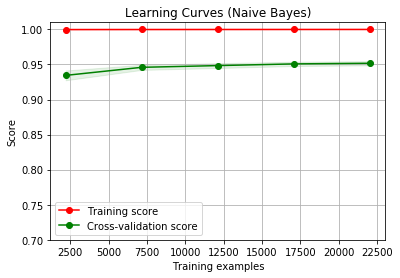

In [88]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
X, y = X_train_prepared, y

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt





title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = AdaBoostClassifier(random_state=9,base_estimator=evc_clf,n_estimators=100)
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)




plt.show()

prediction of 30 samples of test data set

[1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1 1 0 1 0]
[1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1]


Confusion matrix, without normalization
[[1245   89]
 [  58 1364]]
Normalized confusion matrix
[[ 0.93  0.07]
 [ 0.04  0.96]]


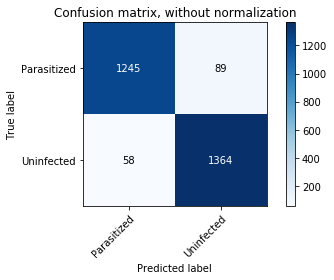

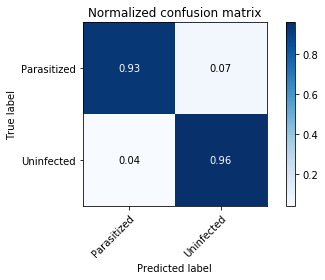

accuracy, recall and precision
[0.94666182873730043, 0.95921237693389594, 0.93874741913282866]


In [110]:
from sklearn.metrics import accuracy_score
y_pred_evc = evc_clf.predict(X_test)
#predict 30 samples of test data set
print('prediction of 30 samples of test data set\n')
print(y_pred_evc[:30])
print(y_test[:30])
print('\n')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_evc, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_evc, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#print accuracy, recall and precision
print('accuracy, recall and precision')
evc_stats=clf_stastics(evc_clf,X_test)
print(evc_stats)


In [78]:
%%time
adb_clf=AdaBoostClassifier(random_state=9,base_estimator=evc_clf,n_estimators=100)
adb_clf.fit(X_train,y_train)

Wall time: 33.2 s


prediction of 30 samples of test data set

[1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1 0 0 1 0]
[1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1]


Confusion matrix, without normalization
[[1257   77]
 [  55 1367]]
Normalized confusion matrix
[[ 0.94  0.06]
 [ 0.04  0.96]]


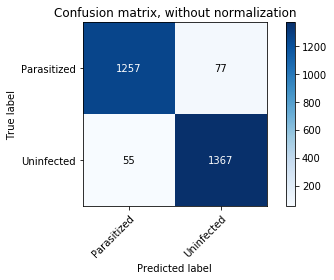

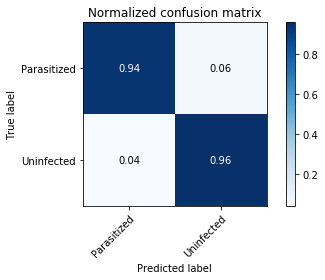

accuracy, recall and precision
[0.95210449927431062, 0.96132208157524612, 0.94667590027700832]


In [111]:
from sklearn.metrics import accuracy_score
y_pred_adb = adb_clf.predict(X_test)
#predict 30 samples of test data set
print('prediction of 30 samples of test data set\n')
print(y_pred_lgr[:30])
print(y_test[:30])
print('\n')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_adb, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_adb, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#print accuracy, recall and precision
print('accuracy, recall and precision')
adb_stats=clf_stastics(adb_clf,X_test)
print(adb_stats)


In [80]:
from sklearn.metrics import accuracy_score
y_pred_adb=adb_clf.predict(X_test)
print(y_pred_adb[30:60])
print(y_test[30:60])
print(accuracy_score(y_test,y_pred_adb))

[0 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0 1 1 1 0 0 1 0 0 1 1 1 0 0]
[0 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 0 0]
0.954644412191582


In [ ]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split

from sklearn_evaluation import plot

data = datasets.make_classification(200, 10, 5, class_sep=0.65)
X = data[0]
y = data[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

est = RandomForestClassifier()
est.fit(X_train, y_train)

y_pred = est.predict(X_test)
y_score = est.predict_proba(X_test)
y_true = y_test

plot.precision_recall(y_true, y_score)

Automatically created module for IPython interactive environment


ValueError: X has 2 features per sample; expecting 532

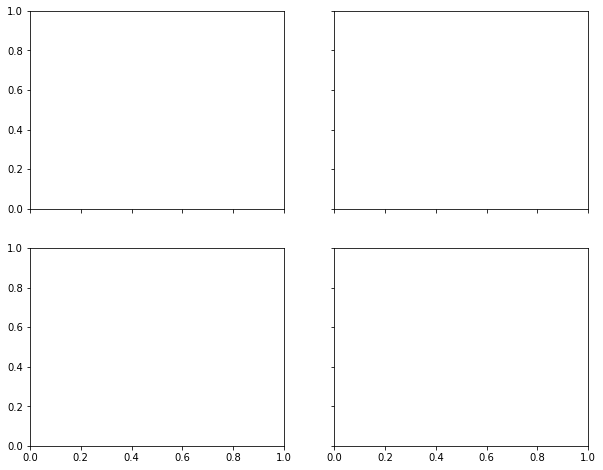

In [193]:
print(__doc__)

from itertools import product

# Plotting decision regions
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [sgd_clf, lgr_clf, dtc_clf, evc_clf],
                        ['Decision Tree (depth=4)', 'KNN (k=7)',
                         'Kernel SVM', 'Soft Voting']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X_test[:, 0], X_test[:, 1], c=y_train,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

In [198]:
stats=pd.DataFrame({"sgd":sgd_stats,"lgr":lgr_stats,"dtc":dtc_stats,"evc":evc_stats,"adb":adb_stats},index=["accuracy","recall","precision"])
stats

NameError: name 'sgd_stats' is not defined

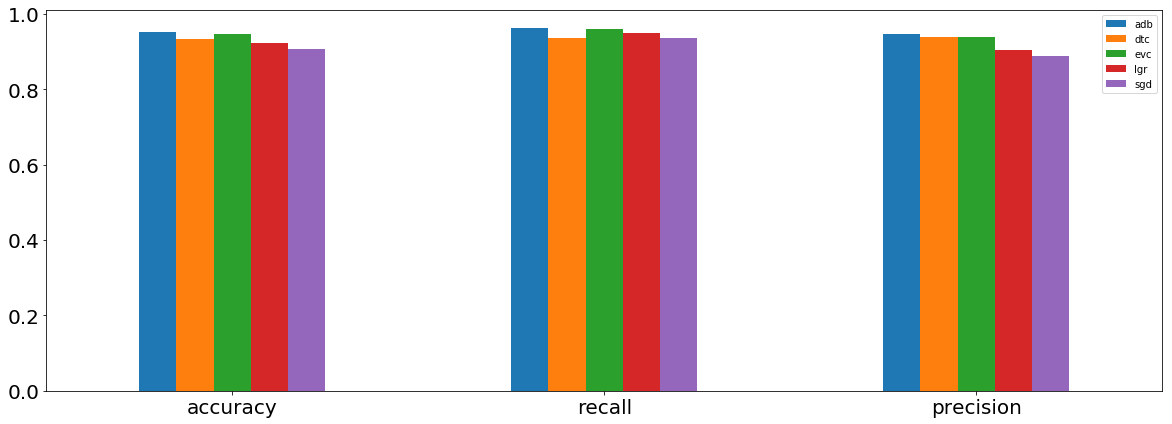

In [121]:

stats.plot.bar(rot=0,figsize=(20,7),fontsize =20)

  